In [154]:
import csv
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

RANDOM_SEED = 42

In [155]:
# dataset = Path('gestures_dataset_new.csv')
DATASET_CSV = Path('../gestures_dataset.csv')
DATASET_ROOT = Path('../ai_data/vgt-all')

In [156]:
%load_ext autoreload
%autoreload 2
from sl_ai.gesture_classifier import GestureClassifier
from sl_ai.dataset import GestureDataset

gesture_dataset: GestureDataset = GestureDataset(DATASET_ROOT)
gesture_dataset.load_from_csv(DATASET_CSV)
classifier: GestureClassifier = GestureClassifier(gesture_dataset=gesture_dataset)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
belgië(0 -> 0) 0 0 0
belgië(0 -> 0) 0 1 0
belgië(0 -> 0) 1 0 0
belgië(0 -> 0) 1 1 0
belgië(0 -> 0) 2 0 0
belgië(0 -> 0) 2 1 0
belgië(0 -> 0) 3 0 0
belgië(0 -> 0) 3 1 0
belgië(0 -> 0) 4 0 0
belgië(0 -> 0) 4 1 0
belgië(0 -> 0) 5 0 0
belgië(0 -> 0) 5 1 0
belgië(0 -> 0) 6 0 0
belgië(0 -> 0) 6 1 0
belgië(0 -> 0) 7 0 0
belgië(0 -> 0) 7 1 0
hallo(7 -> 1) 0 0 0
hallo(7 -> 1) 0 1 0
hallo(7 -> 1) 1 0 0
hallo(7 -> 1) 1 1 0
hallo(7 -> 1) 2 0 0
hallo(7 -> 1) 2 1 0
hallo(7 -> 1) 3 0 0
hallo(7 -> 1) 3 1 0
hallo(7 -> 1) 4 0 0
hallo(7 -> 1) 4 1 0
hallo(7 -> 1) 5 0 0
hallo(7 -> 1) 5 1 0
hallo(7 -> 1) 6 0 0
hallo(7 -> 1) 6 1 0
hallo(7 -> 1) 7 0 0
hallo(7 -> 1) 7 1 0
hallo(7 -> 1) 8 0 0
hallo(7 -> 1) 8 1 0
hallo(7 -> 1) 9 0 0
hallo(7 -> 1) 9 1 0
hallo(7 -> 1) 10 0 0
hallo(7 -> 1) 10 1 0
hallo(7 -> 1) 11 0 0
hallo(7 -> 1) 11 1 0
verenigde staten(11 -> 2) 0 0 0
verenigde staten(11 -> 2) 0 1 0
verenigde staten(11 -> 2) 1 

In [157]:
classifier.train(save=True, train_size=.5)
classifier.summary()

Epoch 1/1000
13/13 [==============================] - 0s 11ms/step - loss: 1.3539 - accuracy: 0.3846 - val_loss: 1.1276 - val_accuracy: 0.5714
Epoch 2/1000
13/13 [==============================] - 0s 3ms/step - loss: 1.1864 - accuracy: 0.5385 - val_loss: 1.1085 - val_accuracy: 0.5714
Epoch 3/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.8698 - accuracy: 0.5385 - val_loss: 1.1041 - val_accuracy: 0.5714
Epoch 4/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.9943 - accuracy: 0.5385 - val_loss: 1.0772 - val_accuracy: 0.5714
Epoch 5/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.9885 - accuracy: 0.6154 - val_loss: 1.0353 - val_accuracy: 0.5714
Epoch 6/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.9383 - accuracy: 0.4615 - val_loss: 1.0079 - val_accuracy: 0.5714
Epoch 7/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.8720 - accuracy: 0.6154 - val_loss: 0.9839 - val_accuracy: 0.5714
Epoch

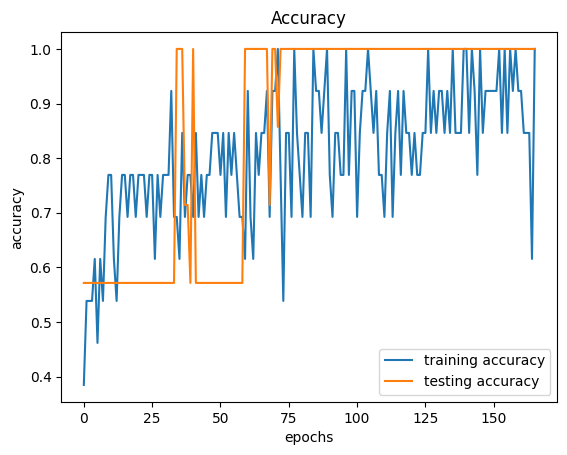

In [158]:
classifier.visualize_accuracy()

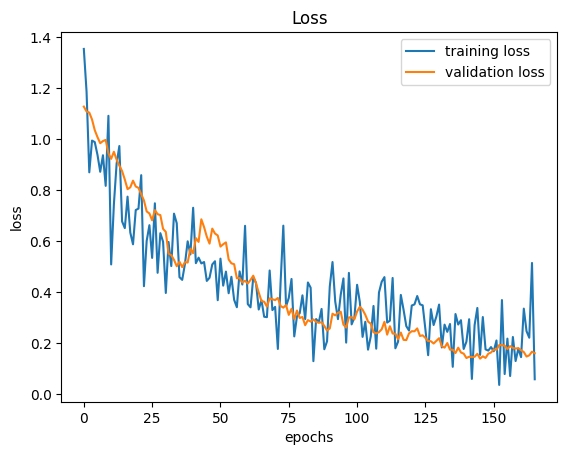

In [159]:
classifier.visualize_loss()

1/1 [==============================] - 0s 37ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         1

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7



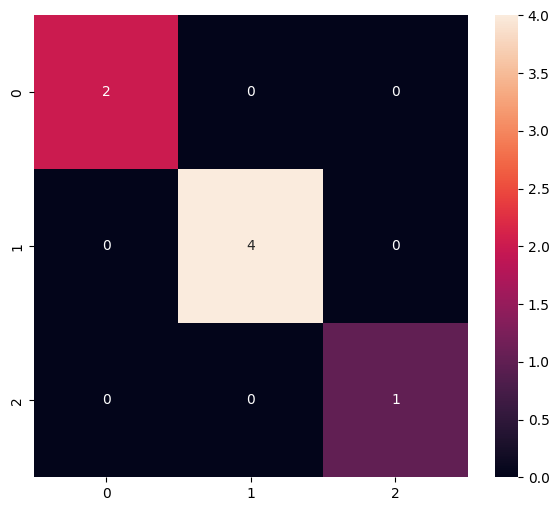

In [160]:
classifier.confusion_matrix()